In [2]:
import pandas as pd
import numpy as np

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GroupShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os



In [3]:
df1 = pd.read_excel("dataset/Complete_Dataframe_def.xlsx")
df2 = pd.read_excel("dataset/Exact_enumeration_task.xlsx")
df3 = pd.read_excel("dataset/Symbolic_comparison_task.xlsx")
df4 = pd.read_excel("dataset/Visuo_spatial_WM_task.xlsx")

In [4]:
df = df1.merge(df2, on="Sub", how="inner", suffixes=("", "_df2"))
df = df.merge(df3, on="Sub", how="inner", suffixes=("", "_df3"))
df = df.merge(df4, on="Sub", how="inner", suffixes=("", "_df4"))

print("Merged shape:", df.shape)



Merged shape: (32768, 34)


In [5]:
df = df1.merge(df2, on="Sub", how="inner", suffixes=("", "_df2"))
df = df.merge(df3, on="Sub", how="inner", suffixes=("", "_df3"))
df = df.merge(df4, on="Sub", how="inner", suffixes=("", "_df4"))

print(df.shape)
df.head()


(32768, 34)


,Sub,Similarities_IQ,MatrixReas_IQ,w_fraction_def,Mean_ACC_ANS,Mean_RTs_ANS,Mean_RTs_def,Mean_ACC_13,Mean_ACC_47,MeanRT_13,...,Accuracy,Group,Distance,RTs_df3,Accuracy_df3,Group_df3,Numerosity_df4,RTs_WM,Accuracy_WM,Group_df4
0,1,16.0,11.0,0.418544,61.71875,1266.90625,1266.90625,0.791667,0.265625,0.719789,...,0.875,DD,1,2297.42,0.75,DD,1,3399.19,0.63,DD
1,1,16.0,11.0,0.418544,61.71875,1266.90625,1266.90625,0.791667,0.265625,0.719789,...,0.875,DD,1,2297.42,0.75,DD,2,2562.63,0.69,DD
2,1,16.0,11.0,0.418544,61.71875,1266.90625,1266.90625,0.791667,0.265625,0.719789,...,0.875,DD,1,2297.42,0.75,DD,3,1573.63,0.88,DD
3,1,16.0,11.0,0.418544,61.71875,1266.90625,1266.90625,0.791667,0.265625,0.719789,...,0.875,DD,1,2297.42,0.75,DD,4,2559.06,0.56,DD
4,1,16.0,11.0,0.418544,61.71875,1266.90625,1266.90625,0.791667,0.265625,0.719789,...,0.875,DD,1,2297.42,0.75,DD,5,1980.88,0.38,DD


In [6]:
# Drop all group-related columns except the main label
leak_cols = [c for c in df.columns if "group" in c.lower() and c != "group"]
df = df.drop(columns=leak_cols)

# Verify
print([c for c in df.columns if "group" in c.lower()])



['group']


In [7]:
y = df["group"]          # 1 = Dyscalculia, 0 = Control
groups = df["Sub"]       # subject ID for safe splitting

X = df.drop(["group", "Sub"], axis=1)

# Ensure all features are numeric
X = X.apply(pd.to_numeric, errors="coerce")


In [8]:
imputer = SimpleImputer(strategy="mean")
X = imputer.fit_transform(X)

scaler = StandardScaler()
X = scaler.fit_transform(X)



In [9]:
gss = GroupShuffleSplit(test_size=0.2, random_state=42)
train_idx, test_idx = next(gss.split(X, y, groups))

X_train, X_test = X[train_idx], X[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]



In [10]:
model = RandomForestClassifier(
    n_estimators=300,
    max_depth=12,
    random_state=42,
    class_weight="balanced"
)

model.fit(X_train, y_train)



,n_estimators,300
,criterion,'gini'
,max_depth,12
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [11]:
y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))



Accuracy: 0.6520432692307693

Classification Report:
               precision    recall  f1-score   support

          DD       0.59      0.83      0.69      3072
       contr       0.78      0.50      0.61      3584

    accuracy                           0.65      6656
   macro avg       0.68      0.66      0.65      6656
weighted avg       0.69      0.65      0.64      6656


Confusion Matrix:
 [[2560  512]
 [1804 1780]]


In [12]:
# Using one real sample structure
new_student = X_test[0].reshape(1, -1)

prediction = model.predict(new_student)

if prediction[0] == 1:
    print("⚠ Dyscalculia detected")
else:
    print("✅ No Dyscalculia detected")


✅ No Dyscalculia detected


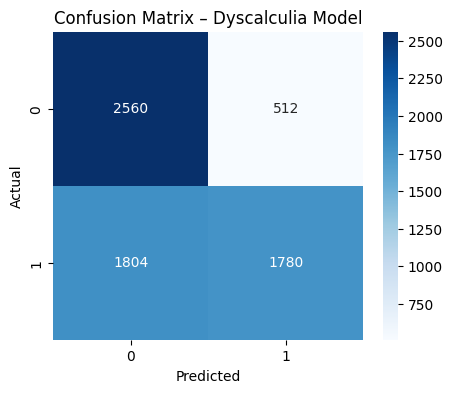

In [13]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix – Dyscalculia Model")
plt.show()



In [14]:
os.makedirs("model", exist_ok=True)

joblib.dump(model, "model/trained_model.pkl")
joblib.dump(scaler, "model/scaler.pkl")

print("✅ Model and scaler saved")




✅ Model and scaler saved


In [15]:
sample_student = X_test[0].reshape(1, -1)
prediction = model.predict(sample_student)

if prediction[0] == 1:
    print("⚠ Dyscalculia detected")
else:
    print("✅ No Dyscalculia detected")


✅ No Dyscalculia detected


In [16]:
from sklearn.model_selection import GridSearchCV, GroupKFold

param_grid = {
    "n_estimators": [300, 500],
    "max_depth": [10, 14, None],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 2]
}

rf = RandomForestClassifier(
    random_state=42,
    class_weight="balanced"
)

gkf = GroupKFold(n_splits=5)

grid = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=gkf,
    scoring="f1",
    n_jobs=-1
)

grid.fit(X, y, groups=groups)

print("✅ Best Parameters:", grid.best_params_)


c:\Users\work\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_search.py:1135: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan]
  warnings.warn(


✅ Best Parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}


In [17]:
best_rf = grid.best_estimator_


In [18]:
best_rf.fit(X_train, y_train)

y_pred = best_rf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 0.6799879807692307
              precision    recall  f1-score   support

          DD       0.61      0.83      0.71      3072
       contr       0.79      0.55      0.65      3584

    accuracy                           0.68      6656
   macro avg       0.70      0.69      0.68      6656
weighted avg       0.71      0.68      0.68      6656

